In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
if len(tf.config.list_physical_devices('GPU')):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Loading data

In [3]:
dataset = pd.read_csv("train_data_percentage", index_col=0)
dataset = dataset.dropna()
dataset = (dataset[(dataset.lang=="en")]).reset_index(drop=True).sort_index()
dataset = dataset.reset_index(drop=True).sort_index()

In [4]:
# Create categories from priceChanges
stepKey = "1stepChange"
threshold = 0.005
dataset.insert(loc=9,column="priceChangeClass", value=1)
dataset.at[dataset[dataset[stepKey] <= (1-threshold)].index, "priceChangeClass"] = 0
dataset.at[dataset[dataset[stepKey] >= (1+threshold)].index, "priceChangeClass"] = 2

In [5]:
smallest_amount_data = min(dataset.priceChangeClass.value_counts())

indexes = []
for unique_class in set(dataset.priceChangeClass):
        temp_indexes = dataset.loc[dataset.priceChangeClass==unique_class].sample(smallest_amount_data).index
        #print(list(temp_indexes))
        indexes += list(temp_indexes)

In [6]:
balanced_dataset = dataset.loc[indexes].sample(frac=1).reset_index(drop=True)

In [7]:
#TODO: remove 
balanced_dataset = balanced_dataset.sample(n=10000).reset_index(drop=True).sort_index()

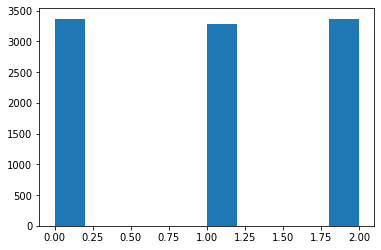

In [8]:
plt.hist(balanced_dataset.priceChangeClass)
plt.show()

In [9]:
seed = 12345

val_percent = 0.1
test_percent = 0.2

validation_data = (balanced_dataset.sample(frac=val_percent, random_state=seed)).reset_index(drop=True)
test_data = (balanced_dataset.sample(frac=test_percent, random_state=seed)).reset_index(drop=True)
train_data = (balanced_dataset.iloc[balanced_dataset.index.difference(test_data.index).difference(validation_data.index)]).reset_index(drop=True)

In [10]:
train_data

,datetime,headline,summary,related,lang,source,1stepChange,2stepChange,3stepChange,priceChangeClass,6stepChange
0,2020-11-20 07:10:59-05:00,"In pandemic Christmas, US rivals aim to challe...","Walmart Inc, Best Buy Co Inc and hundreds of s...",BBY,en,Channel NewsAsia,1.008584,1.004208,1.005891,2,1.011530
1,2020-06-03 10:45:33-05:00,Vale singer turns heads after wowing star judg...,Boy George and Kelly Rowland turned their chai...,VALE,en,The Daily Record,0.994398,0.995798,0.992530,0,0.979458
2,2019-08-13 16:23:37-05:00,Here are the latest executive power moves that...,Keeping an eye on major hires and promotions i...,PANW,en,Business Insider,0.999551,0.999102,0.988054,1,0.981766
3,2020-10-24 09:18:46-05:00,Freeport-McMoRan (NYSE:FCX) Price Target Incre...,Freeport-McMoRan (NYSE:FCX) had its target pri...,FCX,en,Transcript Daily,0.992375,0.980937,0.985839,0,0.979847
4,2020-09-11 04:00:24-05:00,"'We're compiling lessons learned': GM, Faceboo...",Employers such as GM ponder office space and w...,GM,en,USA Today,1.013907,1.016556,1.013907,2,1.011589
...,...,...,...,...,...,...,...,...,...,...,...
7995,2020-07-28 07:24:39-05:00,FXNEWS24 |JPMorgan partners with Marqeta to la...,JPMorgan partners with Marqeta to launch 'virt...,JPM,en,FXNews24,1.001557,1.000830,1.000623,1,1.009102
7996,2020-03-19 00:15:03-05:00,China Mobile : to Accelerate 5G Rollout as Ful...,By Martin Mou China Mobile Ltd. on Thursday sa...,CHL,en,MarketScreener,1.002581,1.018065,1.000645,1,1.020968
7997,2019-12-11 12:05:11-05:00,Yamal LNG's 15-Vessel Fleet of Icebreaking LNG...,The fifteenth and final icebreaking LNG carrie...,TGP,en,gCaptain,1.006566,1.006566,1.011819,2,1.005253
7998,2019-05-30 15:29:14-05:00,Williams-Sonoma +11% as profit view improves,No summary available.,WSM,en,Seeking Alpha,1.000387,0.999032,1.121975,1,1.105518


## Loading bert model and preprocessor

In [13]:
small_bert_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
small_bert_preprocessor = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2"


#TODO: fix sequence length?
seq_length=512
bert_preprocess_model = hub.KerasLayer(small_bert_preprocessor)
bert_preprocess = hub.load(small_bert_preprocessor)
bert_model = hub.KerasLayer(small_bert_url)

In [14]:
tt = "Indian shares fell on Wednesday after the International Monetary Fund cut its economic growth forecast for the country for the second time in nearly four months, while Wipro's quarterly profit miss also weighed on sentiment."
tok = bert_preprocess.tokenize(tf.constant([tt]))
text_preprocessed = bert_preprocess.bert_pack_inputs([tok], tf.constant(seq_length))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)


Shape Word Ids :  (1, 512)
Shape Mask     :  (1, 512)
Shape Type Ids :  (1, 512)


## Test code

In [15]:
def make_bert_preprocess_model(sentence_features, seq_length=512):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.
    TODO: could have headline and summary here

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(small_bert_preprocessor)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [16]:
test_preprocess_model = make_bert_preprocess_model(['sentence'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_mask', 'input_word_ids', 'input_type_ids']
Shape Word Ids :  (1, 512)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102    0    0    0    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 512)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 512)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


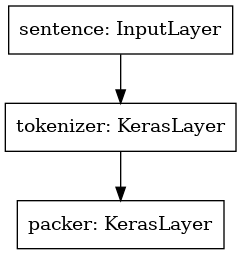

In [17]:
tf.keras.utils.plot_model(test_preprocess_model)

In [18]:
def build_classifier_model(num_classes):
  inputs = dict(
      input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
  )

  encoder = hub.KerasLayer(small_bert_url, trainable=True, name='encoder')
  net = encoder(inputs)['pooled_output']
  net = tf.keras.layers.Dropout(rate=0.1)(net)
  net = tf.keras.layers.Dense(64, activation="relu", name='dense1')
  net = tf.keras.layers.Dense(num_classes,  name='classifier')(net)
  return tf.keras.Model(inputs, net, name='prediction')

In [19]:
test_classifier_model = build_classifier_model(3)
bert_raw_result = test_classifier_model(text_preprocessed)
print(bert_raw_result)

tf.Tensor([[0.08233427 0.34759623 0.5700695 ]], shape=(1, 3), dtype=float32)


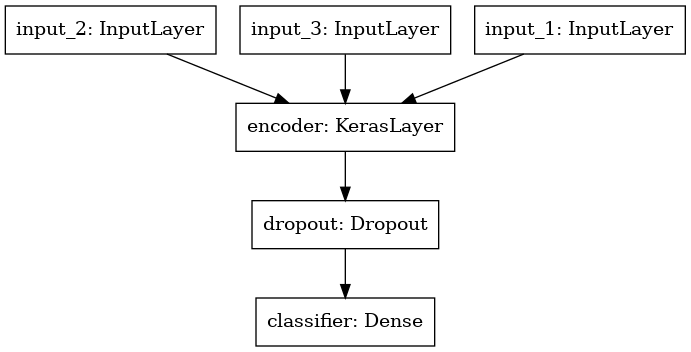

In [20]:
tf.keras.utils.plot_model(test_classifier_model)


In [21]:
x_train = test_preprocess_model(np.array(train_data.summary))
y_train = np.array(train_data.priceChangeClass).astype(np.int8)

val_x = test_preprocess_model(np.array(validation_data.summary))
val_y = np.array(validation_data.priceChangeClass)

test_x = test_preprocess_model(np.array(test_data.summary))
test_y = np.array(test_data.priceChangeClass).astype(np.int8)

In [ ]:
#x_train = test_preprocess_model(np.array(train_data.summary)[:1000])


In [23]:
epochs = 1
batch_size = 4
init_lr = 2e-5

steps_per_epoch = len(train_data.index) // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10
validation_steps = len(validation_data.index)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

test_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

test_classifier_model.fit(
    x=x_train,
    y=y_train,
    validation_data=(val_x, val_y),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_steps=validation_steps)


2000/2000 [==============================] - 359s 180ms/step - loss: 1.1043 - accuracy: 0.3526 - val_loss: 1.0939 - val_accuracy: 0.3720


In [25]:
pred = test_classifier_model.predict(test_x)

In [26]:
#tf.math.confusion_matrix(labels=test_y, predictions=res)

rez = []
for elem in pred:
    aa = tf.math.argmax(elem)
    rez.append(aa.numpy())

rez = np.array(rez)    
np.count_nonzero(rez == test_y) / len(rez)


0.3675

In [27]:
tf.math.confusion_matrix(labels=test_y, predictions=rez)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[411, 228,  35],
       [334, 275,  29],
       [413, 226,  49]], dtype=int32)>

# Own code

In [44]:
preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2")

# Step 1: tokenize batches of text inputs.
text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)
               ] # This SavedModel accepts up to 2 text inputs.
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

# Step 3: pack input sequences for the Transformer encoder.
seq_length = 128  # Your choice here.
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))  # Optional argument.
encoder_inputs = bert_pack_inputs(tokenized_inputs)

### Preprocess some text

In [52]:
test_text = ["ValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on Saturday morning, ValuEngine reports. SKX has been the topic of several other reports. 140166 increased their price objective on Skechers USA from $32.00 to $39.00 in a research report on Friday, July"]

text_preprocessed = bert_preprocess_model(test_text)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')
len(test_text[0].split())

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [[  101  3643  3070  3170  9725  6661  1997 15315 27635  2869  3915  1006
   6396  3366  1024 15315  2595  1007  2013  1037  2907  5790  2000  1037
   4965  5790  1999  1037  2470  3602  3843  2000  9387  2006  5095 10175
  24997 11528  2063  9725  6661  1997 15315 27635  2869  3915  1006  6396
   3366  1024 15315  2595  1007  2013  1037  2907  5790  2000  1037  4965
   5790  1999  1037  2470  3602  3843  2000  9387  2006  5095 10175 24997
  11528  2063  9725  6661  1997 15315 27635  2869  3915  1006  6396  3366
   1024 15315  2595  1007  2013  1037  2907  5790  2000  1037  4965  5790
   1999  1037  2470  3602  3843  2000  9387  2006  5095 10175 24997 11528
   2063  9725  6661  1997 15315 27635  2869  3915  1006  6396  3366  1024
  15315  2595  1007  2013  1037  2907  5790   102]]
Input Mask : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 

193

In [13]:
bert_results = bert_model(text_preprocessed)

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9824908   0.76062226 -0.03692193  0.12203462  0.39114746  0.41416568
  0.9954358  -0.89795995 -0.38491482 -0.9893756  -0.20844996 -0.6297051 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.43924457 -0.13059938  0.90825254 ... -0.8680172   0.5541188
   0.8547666 ]
 [-0.23845711 -0.5364785   0.29254144 ... -0.39248142  0.74903923
  -0.4524054 ]
 [-0.4771736   0.39477485 -0.3236331  ... -0.69937664 -0.07088979
  -0.21797672]
 ...
 [-0.90205806  1.7535473   0.75899905 ... -0.6645514   0.48757368
   0.9621246 ]
 [-0.07816001  0.5708613   0.01111203 ... -0.34754694  0.8900679
   0.82887846]
 [-0.132772   -0.16776928 -0.7433138  ... -0.43809432  0.09481239
   0.6366134 ]]


In [14]:
def create_classifier_model():
    text_input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(small_bert_preprocessor, name="preprocessor")
    encoded_input = preprocessing_layer(text_input_layer)
    encoder = hub.KerasLayer(small_bert_url, trainable=True, name="bert_encoder")
    outputs = encoder(encoded_input)
    net = outputs["pooled_output"]
    #net = tf.keras.layers.Dropout(0.1)(net)
    net= tf.keras.layers.Dense(512, activation="relu", name="layer1")(net)
    net= tf.keras.layers.Dense(256, activation="relu", name="layer2")(net)
    net= tf.keras.layers.Dense(128, activation="relu", name="layer3")(net)
    net= tf.keras.layers.Dense(64, activation="relu", name="layer4")(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name="classifier")(net)
    return tf.keras.Model(text_input_layer, net)

In [15]:
classifier_model = create_classifier_model()
bert_raw_result = classifier_model(tf.constant(test_text))
print(bert_raw_result)
#print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.33550596 0.2979216  0.3665724 ]], shape=(1, 3), dtype=float32)


In [16]:
tf.keras.utils.plot_model(classifier_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [17]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.metrics.SparseCategoricalCrossentropy()

In [18]:
epochs = 1
steps_per_epoch = len(train_data.index)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [19]:
classifier_model.compile(optimizer=optimizer,
                        loss=loss_function,
                        metrics=metric)

In [20]:
x_train = np.array(train_data.summary)
y_train = np.array(train_data.priceChangeClass).astype(np.int8)

#x_train = x_train[:50000]
#y_train = y_train[:50000]

#x_train
history = classifier_model.fit(x_train, y_train, batch_size=16)
#y_train

9785/9785 [==============================] - 1432s 146ms/step - loss: 1.0935 - sparse_categorical_crossentropy: 1.0935


In [21]:

test_x = np.array(test_data.summary)
test_y = np.array(test_data.priceChangeClass).astype(np.int8)

#res = classifier_model.evaluate(test_x, test_y)
#print("test loss, test acc:", res)


In [22]:
pred = classifier_model.predict(test_x)

In [23]:
pred

array([[0.3413031 , 0.3865437 , 0.27215323],
       [0.2885768 , 0.42704913, 0.28437406],
       [0.31216136, 0.36993355, 0.3179051 ],
       ...,
       [0.28031448, 0.50544816, 0.21423742],
       [0.31894097, 0.3757555 , 0.30530357],
       [0.3254851 , 0.3275079 , 0.347007  ]], dtype=float32)

In [24]:
#tf.math.confusion_matrix(labels=test_y, predictions=res)

rez = []
for elem in pred:
    aa = tf.math.argmax(elem)
    rez.append(aa.numpy())

In [25]:
rez = np.array(rez)

In [26]:
np.count_nonzero(rez == test_y) / len(rez)

0.392973939703628

In [27]:
tf.math.confusion_matrix(labels=test_y, predictions=rez)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1002, 7329, 4729],
       [ 663, 9490, 2948],
       [ 997, 7093, 4889]], dtype=int32)>

In [28]:
m = tf.keras.metrics.Accuracy()
m.update_state(rez, test_y)
m.result().numpy()

0.39297393

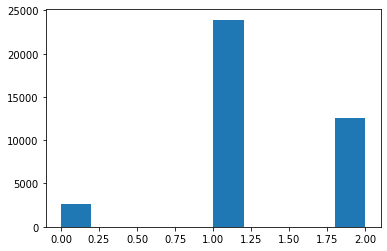

In [29]:
plt.hist(rez)
plt.show()

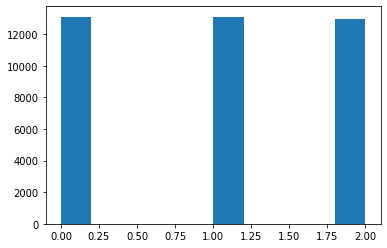

In [30]:
plt.hist(test_y)
plt.show()

In [39]:
print(history.history.keys())


NameError: name 'history' is not defined

In [32]:
train_data

,index,datetime,headline,summary,related,lang,source,priceChangeClass
0,70899,2020-10-19 21:03:14-05:00,Skechers USA (NYSE:SKX) Lifted to “Buy” at Val...,ValuEngine upgraded shares of Skechers USA (NY...,SKX,en,Stock Observer,1
1,70900,2020-10-08 15:05:00-05:00,"SKECHERS USA, Inc. to Report Third Quarter 202...","MANHATTAN BEACH, Calif.--(BUSINESS WIRE)--SKEC...",SKX,en,Business Wire,0
2,70901,2020-10-02 01:00:00-05:00,Footwear Market will Showcase Negative Impact ...,Technavio has been monitoring the footwear mar...,SKX,en,Benzinga,0
3,70902,2020-09-24 14:27:56-05:00,Jon Najarian Sees Unusual Options Activity In ...,"On CNBC's ""Fast Money Halftime Report,"" Jon Na...",SKX,en,Benzinga,1
4,70903,2020-09-02 15:05:00-05:00,Skechers Announces Virtual Participation at th...,"MANHATTAN BEACH, Calif.--(BUSINESS WIRE)--SKEC...",SKX,en,Business Wire,1
...,...,...,...,...,...,...,...,...
283591,354490,2019-02-19 13:08:09-05:00,"Advance Auto Parts, Inc. (AAP) CEO Tom Greco o...",No summary available.,AAP,en,Seeking Alpha,1
283592,354491,2019-02-19 06:50:47-05:00,Advance Auto Parts lower post Q4 results,No summary available.,AAP,en,Seeking Alpha,0
283593,354492,2019-02-19 06:42:14-05:00,Advance Auto Parts declares $0.06 dividend,No summary available.,AAP,en,Seeking Alpha,0
283594,354493,2019-02-19 06:40:42-05:00,"Advance Auto Parts beats by $0.04, revenue in-...",No summary available.,AAP,en,Seeking Alpha,0
